In [1]:
!pip install tensorflow


^C


In [30]:
#Importar librerias
import os
import cv2 
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
#Librería para calculo numerico
import numpy as np
#Libreria para graficacion
import matplotlib.pyplot as plt
#Importa para dividir el conjunto de datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#Importa datos de señales de registro de archivos de ejecuciones de simulación disponibles para la aplicación en tiempo real seleccionadas
import time
import math
import logging

In [3]:
#Definición del tamaño, array de las imagenes
#Pixeles
IMG_SHAPE  = 224
#Imagenes procesadas simultaneamente
batch_size = 32
#Aleatoridad
random_seed = 9

In [4]:
#Carga de datos
fpath = './DataSetClasificado_Recortado'
categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['FASE 0', 'FASE 1', 'FASE 2', 'FASE 3', 'FASE 4', 'FASE 5', 'FASE 6'] 

No. of categories =  7


In [5]:
#Funcion para cargar las imagenes por categorias
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')
            
            img_lst.append(np.array(img_array))
            
            labels.append(index)
    return img_lst, labels
#Cargar las imagenes desde las categorias"""
images, labels = load_images_and_labels(categories)
#Mostrar la cantidad de imagenes cargadas"""
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  1120 
No. of labels loaded =  1120
<class 'list'> <class 'list'>


In [31]:
#Variables para ver el array de las imagenes y los label
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1120, 224, 224, 3) 
Labels shape =  (1120,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


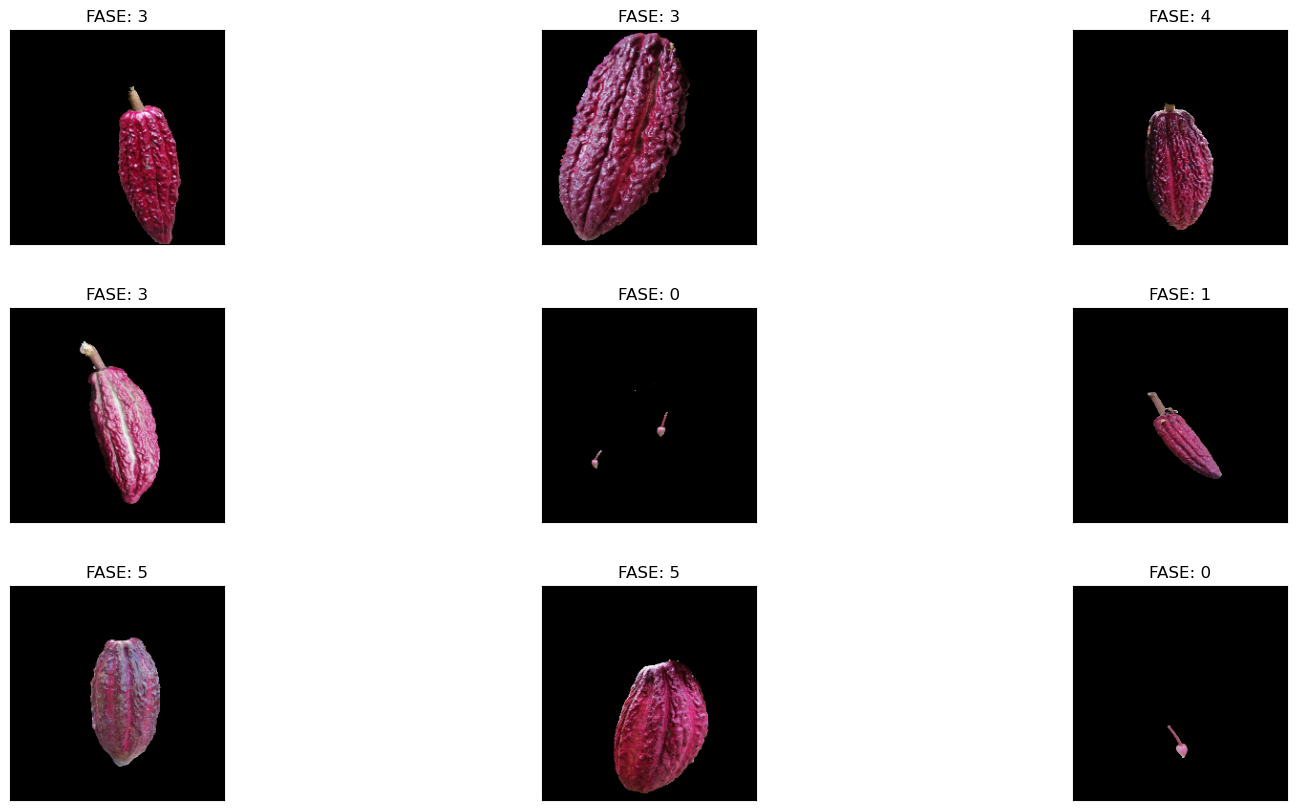

In [7]:
#Función para visualizar imagenes aleatorias 
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])

        plt.title('FASE: {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
#Mostrar imagenes con sus labels    
display_rand_images(images, labels)

In [8]:
# D E F I N I R - D A T O S

#Primero se reorganizan los datos

#Obtener números igualmente espaciados en un rango dado
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#Mezclar todos los valores igualmente espaciados en la lista 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 1117 1118 1119]

'n' values after shuffling =  [ 874 1071  650 ...  638  348  382]


In [9]:
#M E Z C L A - D E - D A T O S
#Aleatoridad
images = images[n]
labels = labels[n]
print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (1120, 224, 224, 3) 
Labels shape after shuffling =  (1120,)


In [10]:
# N O R M A L I Z A R
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (1120, 224, 224, 3)


In [11]:
# D E F I N I R - TESTEO y ENTRENAMIENTO
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]

#Mostrar los array en cada parte del entrenamiento y la prueba

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (838, 224, 224, 3)
y_train shape =  (838,)

x_test shape =  (224, 224, 224, 3)
y_test shape =  (224,)

x_val shape =  (58, 224, 224, 3)
y_val shape =  (58,)


In [12]:
#Estructura One-hot-encode
y_train = to_categorical(y_train, 7)
y_test = to_categorical(y_test, 7)
y_val = to_categorical(y_val, 7)

In [13]:
# MODELO CNN
model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation="relu",input_shape=x_train[0].shape),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation="softmax")
]
)

In [14]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 100)               2

In [16]:
steps_per_epoch = (x_train.shape[0]//batch_size)
validation_steps = (x_val.shape[0] // batch_size)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [17]:
x_train.shape,y_train.shape

((838, 224, 224, 3), (838, 7))

In [32]:
start_time = time.time()

history = model.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 10,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)




Epoch 1/10
26/26 [==============================] - 39s 1s/step - loss: 0.0152 - acc: 0.9964 - val_loss: 1.0328 - val_acc: 0.7812
Epoch 2/10
26/26 [==============================] - 37s 1s/step - loss: 0.0342 - acc: 0.9913 - val_loss: 1.2335 - val_acc: 0.7500
Epoch 3/10
26/26 [==============================] - 38s 1s/step - loss: 0.0153 - acc: 0.9963 - val_loss: 1.3426 - val_acc: 0.7500
Epoch 4/10
26/26 [==============================] - 38s 1s/step - loss: 0.0079 - acc: 0.9988 - val_loss: 1.4058 - val_acc: 0.7188
Epoch 5/10
26/26 [==============================] - 38s 1s/step - loss: 0.0136 - acc: 0.9975 - val_loss: 1.4821 - val_acc: 0.7812
Epoch 6/10
26/26 [==============================] - 38s 1s/step - loss: 0.0163 - acc: 0.9950 - val_loss: 1.1418 - val_acc: 0.8438
Epoch 7/10
26/26 [==============================] - 38s 1s/step - loss: 0.0075 - acc: 1.0000 - val_loss: 1.3297 - val_acc: 0.7188
Epoch 8/10
26/26 [==============================] - 37s 1s/step - loss: 0.0050 - acc: 0.99

#Evaluacion del modelo 
start_time = time.time()

loss, accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)
test_loss = loss * 100.0
test_accuracy = accuracy * 100.0{

print('test_loss: %.2f' % test_loss)
print('test_accuracy: %.2f' % test_accuracy)

logging.info("Evaluation Execution Time: " + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
logging.info("test_loss: " + str(test_loss))
logging.info("test_accuracy: " + str(test_accuracy))

In [19]:
#Metricas
model_probs = model.predict(x_test,batch_size=batch_size,verbose=0)
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_reduced, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 69.20
F1 score: 69.20
Precision: 71.27
Recall: 69.20


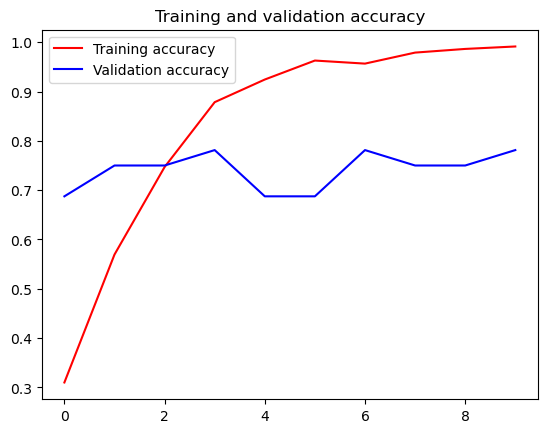

In [20]:
#Graficas
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN-Puro.png")
plt.show()

In [21]:

y_pred = model.predict(x_test)

7/7 [==============================] - 2s 306ms/step


In [22]:

y_pred.round()

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [23]:
accuracy_score(y_test, y_pred.round())*100

68.75

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_pred.round(), y_test))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88        30
           1       0.62      0.86      0.72        28
           2       0.86      0.71      0.78        45
           3       0.36      0.48      0.41        25
           4       0.75      0.42      0.54        36
           5       0.50      0.60      0.55        25
           6       0.83      0.94      0.88        32

   micro avg       0.69      0.70      0.69       221
   macro avg       0.69      0.70      0.68       221
weighted avg       0.72      0.70      0.69       221
 samples avg       0.69      0.69      0.69       221



E:\Programas de la u\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
accuracy = model.evaluate(x_test,y_test,batch_size=32)
print("Accuracy: ",accuracy[1]*100)

7/7 [==============================] - 2s 304ms/step - loss: 1.7459 - acc: 0.6920
Accuracy:  69.19642686843872


In [26]:
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

In [27]:
report = classification_report(Y_true, Y_pred_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support

      FASE 0       0.87      0.90      0.88        29
      FASE 1       0.83      0.64      0.72        39
      FASE 2       0.71      0.86      0.78        37
      FASE 3       0.48      0.36      0.41        33
      FASE 4       0.41      0.75      0.53        20
      FASE 5       0.60      0.50      0.55        30
      FASE 6       0.94      0.83      0.88        36

    accuracy                           0.69       224
   macro avg       0.69      0.69      0.68       224
weighted avg       0.71      0.69      0.69       224



In [28]:
#Matriz de confusion
confusion = confusion_matrix(Y_true,Y_pred_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[26  2  0  1  0  0  0]
 [ 4 25  5  3  2  0  0]
 [ 0  2 32  1  2  0  0]
 [ 0  0  5 12  8  8  0]
 [ 0  1  1  2 15  1  0]
 [ 0  0  1  6  6 15  2]
 [ 0  0  1  0  4  1 30]]


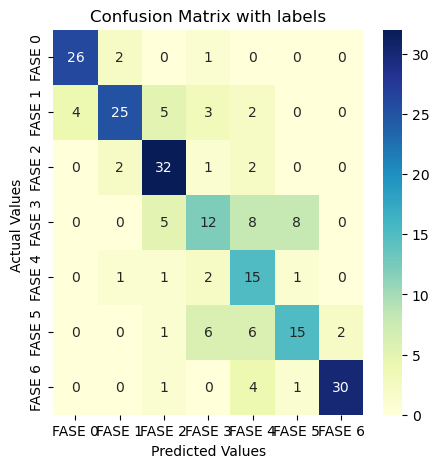

In [29]:
import seaborn as sns
plt.figure(figsize=(5, 5))

ma = sns.heatmap(confusion, cmap="YlGnBu", annot=True)
ma.set_title('Confusion Matrix with labels')
ma.set_xlabel('Predicted Values')
ma.set_ylabel('Actual Values ')
ma.xaxis.set_ticklabels(categories)
ma.yaxis.set_ticklabels(categories)

plt.show()